In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from tqdm import notebook
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
device = 'mps:0' if torch.backends.mps.is_available else 'cpu'

In [3]:
start_time = '2010-01-01'
end_time   = '2024-03-31'

samsung = yf.download('005930.KS',start_time,end_time)
kospi   = yf.download('^KS11',start_time,end_time)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
samsung_=samsung.drop(columns=['Volume','Adj Close'])
samsung_mean = pd.DataFrame()
samsung_mean['mean'] = samsung_.mean(axis=1)
subtract = samsung_.apply(lambda x: x.sub(samsung_mean['mean'],axis=0))
samsung_mean_4columns = np.abs(subtract).sum(axis=1)/samsung_mean['mean']
samsung_mean_4columns

Date
2010-01-04    0.018628
2010-01-05    0.021871
2010-01-06    0.032364
2010-01-07    0.067715
2010-01-08    0.026928
                ...   
2024-03-25    0.043120
2024-03-26    0.013797
2024-03-27    0.017599
2024-03-28    0.039950
2024-03-29    0.034251
Length: 3511, dtype: float64

In [5]:
Kospi_=kospi.drop(columns=['Volume','Adj Close'])
Kospi_mean = pd.DataFrame()
Kospi_mean['mean'] = Kospi_.mean(axis=1)
subtract = Kospi_.apply(lambda x: x.sub(Kospi_mean['mean'],axis=0))
Kospi_mean_4columns = np.abs(subtract).sum(axis=1)/Kospi_mean['mean']
Kospi_mean_4columns

Date
2010-01-04    0.017088
2010-01-05    0.015891
2010-01-06    0.010714
2010-01-07    0.025920
2010-01-08    0.023117
                ...   
2024-03-25    0.018545
2024-03-26    0.013113
2024-03-27    0.009863
2024-03-28    0.007848
2024-03-29    0.010570
Length: 3509, dtype: float64

In [6]:
df_name = kospi.columns
rename = ['kospi_' + x for x in df_name]
kospi.columns = rename

In [7]:
df = pd.concat([samsung,kospi],axis=1)

In [8]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume
Date,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.590820,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.282227,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.663086,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.367188,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0


In [9]:
df['fluctuation']       = samsung_mean_4columns
df['kospi_fluctuation'] = Kospi_mean_4columns

In [10]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume,fluctuation,kospi_fluctuation
Date,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.590820,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0,0.018628,0.017088
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0,0.021871,0.015891
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0,0.032364,0.010714
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.282227,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0,0.067715,0.025920
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.663086,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0,0.026928,0.023117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0,0.043120,0.018545
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.367188,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0,0.013797,0.013113
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0,0.017599,0.009863


In [11]:
df.mean()

Open                 4.165784e+04
High                 4.203821e+04
Low                  4.125945e+04
Close                4.164281e+04
Adj Close            3.653969e+04
Volume               1.467664e+07
kospi_Open           2.201338e+03
kospi_High           2.211649e+03
kospi_Low            2.188031e+03
kospi_Close          2.200160e+03
kospi_Adj Close      2.200160e+03
kospi_Volume         4.963545e+05
fluctuation          3.012735e-02
kospi_fluctuation    1.671108e-02
dtype: float64

In [12]:
df = df.fillna(df.mean())

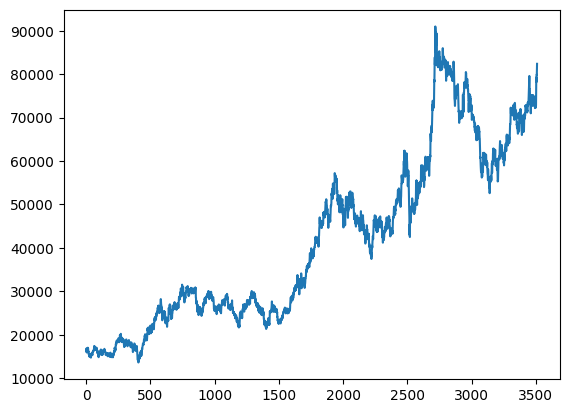

In [13]:
plt.plot(np.arange(len(df)),df['Close'])

In [14]:
label_number = np.arange(0,10)
label_list   = []

In [15]:
label_np= np.zeros(len(df))

for i in range(1,len(df)):
    label_np[i] = np.where(df['Close'].iloc[i]>df['Close'].iloc[i-1],1,0)

In [16]:
df['label']=label_np

In [17]:
df['label']

Date
2010-01-04    0.0
2010-01-05    1.0
2010-01-06    1.0
2010-01-07    0.0
2010-01-08    1.0
             ... 
2024-03-25    0.0
2024-03-26    1.0
2024-03-27    0.0
2024-03-28    1.0
2024-03-29    1.0
Name: label, Length: 3511, dtype: float64

In [18]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume,fluctuation,kospi_fluctuation,label
Date,,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.590820,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0,0.018628,0.017088,0.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0,0.021871,0.015891,1.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0,0.032364,0.010714,1.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.282227,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0,0.067715,0.025920,0.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.663086,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0,0.026928,0.023117,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0,0.043120,0.018545,0.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.367188,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0,0.013797,0.013113,1.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0,0.017599,0.009863,0.0


In [19]:
df.shape

(3511, 15)

In [20]:
class NN_and_data(nn.Module):
    def __init__(self,seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch):
        super(NN_and_data,self).__init__()
        
        self.seq_len     = seq_len
        self.batch_size  = batch_size 
        self.datafile    = data_file


        
        
        self.Conv1   = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,3))
        self.Conv2   = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(2,3))
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(32*2*12,1)

        
    def Make_window_Data(self):
        privious_day = []
        nextday      = []
        scaler       = MinMaxScaler()
        for index in range(len(self.datafile)-self.seq_len):

            seq_len_data = self.datafile.iloc[index:index+seq_len,:-1]
            next_data    = self.datafile.iloc[index+seq_len,-1]

            sc_seq_len_data = scaler.fit_transform(seq_len_data)

            privious_day.append(sc_seq_len_data)
            nextday.append(next_data)
        return np.array(privious_day),np.array(nextday)

    def Data_and_DataLoader(self):
        x,y      = NN_and_data.Make_window_Data(self)
        
        train_x,test_x,train_y,test_y =  train_test_split(x,y,test_size=0.07,shuffle=False)
        
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        test_x  = torch.FloatTensor(test_x)
        test_y  = torch.FloatTensor(test_y)
        train_x = train_x.view(len(train_x),1,self.seq_len,train_x.shape[-1])
        test_x  = test_x.view(len(test_x),1,self.seq_len,test_x.shape[-1])
        Train_datasets  = TensorDataset(train_x,train_y)
        Test_datasets   = TensorDataset(test_x,test_y)
        
            
        Train_Data_Loader = torch.utils.data.DataLoader(dataset=Train_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        
        Test_Data_Loader  = torch.utils.data.DataLoader(dataset=Test_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        return Train_Data_Loader,Test_Data_Loader,test_x,test_y        
        

        
    def forward(self,x):

        x = self.Conv1(x)

        
        x = F.relu(x)
        
        x = self.Conv2(x)
        x = F.relu(x)
        x = self.flatten(x)
        
#         print(x.size())
        
#         x = self.fc1(x)

#         x = F.sigmoid(x)
        
#         print(x[0])
        return x
    
    

In [21]:
class Train_Predict():
    
    def __init__(self,epochs,data_file,each_epoch,seq_len,Data_Loader,criterion):
        
        super(Train_Predict,self).__init__()
        
        self.each_epoch  = each_epoch
        self.lr          = lr
        self.epochs      = epochs
        self.seq_len     = seq_len
        self.Data_Loader = Data_Loader 
        self.criterion   = criterion 
        
    def Training(self):

        optimizer = optim.Adam(model.parameters(),lr=self.lr)
#         model.train().to(device)
        model.train()

        loss_list = np.zeros(self.epochs)
        check_point = 0
        for i in notebook.tqdm(range(self.epochs)):
            
            avg_loss = 0
            length   = len(self.Data_Loader)

            for data,target in self.Data_Loader:
                
                target      = target.view(-1,1)
#                 data,target = data.to(device),target.to(device)

                optimizer.zero_grad()

                output = model(data)
                
   
                loss   = self.criterion(output,target)
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()/length
                loss_list[i]  = avg_loss

                
            if i%self.each_epoch == 0 and i!=0:
                
                print(i,avg_loss)
                
                torch.save({'model':'model','epoch':self.epochs,
                           'model_state_dict':model.state_dict(),
                           'optimzer_state_dict':optimizer.state_dict(),
                           'avg_loss':avg_loss,
                           'check_point':f'custommodel_check_point - {check_point}'
                           },f'./save/model_{seq_len}_splited_samsung-{check_point}_CNN_kospi_multi.pt')
                check_point +=1 
                
                if loss_list[i-each_epoch]<loss_list[i]:
                    
                    torch.save({'model':'model','epoch':self.epochs,
                   'model_state_dict':model.state_dict(),
                   'optimzer_state_dict':optimizer.state_dict(),
                   'loss_list':loss_list,
                   },f'./save/model_{seq_len}_splited_samsung_CNN_kospi_multi.pt')
                    break 
#         torch.save(model,f'./{model}_{seq_len}_splited_apple.pt')
        torch.save({'model':'model','epoch':self.epochs,
               'model_state_dict':model.state_dict(),
               'optimzer_state_dict':optimizer.state_dict(),
               'loss_list':loss_list,
               },f'./save/model_{seq_len}_splited_samsung_CNN_kospi_multi.pt')

        return loss_list

#     def predict(self):

#         model.eval().to(device)
#         test_loss = 0
#         correct   =0

#         with torch.no_grad():

#             for index,(data,label) in enumerate(self.Data_Loader):

#                 data=data.to(device)
#                 label=label.to(device).view(-1,1)

#                 output     = model(data)
#                 test_loss += criterion(output,label).item()
#                 pred       = torch.where(output<0.5,0,1)


#                 correct += pred.eq(label.view_as(pred)).sum().item()

#         accuracy = (100 * correct)/len(self.Data_Loader.dataset)
        
    def predict(self):

#         model.eval().to(device)
        model.eval()
        test_loss = 0
        correct   = 0 
        pred_list = []
        with torch.no_grad():

#             test_x = test_x.to(device)
#             test_y = test_y.to(device)
            output     = model(test_x)
#             test_loss += criterion(test_x,test_y).item()
            pred       = torch.where(output<0.5,0,1)


            correct    += pred.eq(test_y.view_as(pred)).sum().item()
#             pred_list.append((np.array(pred)).item())
            pred_nump = pred.squeeze().numpy()
        accuracy = (100 * correct)/len(self.Data_Loader.dataset)    
    
        return accuracy,pred_nump

In [22]:
class NN_and_data_(nn.Module):
    def __init__(self,seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size):
        super(NN_and_data_,self).__init__()
        
        self.seq_len     = seq_len
        self.batch_size  = batch_size 
        self.datafile    = data_file


        
        
        self.Conv1   = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,3))
        self.Conv2   = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(2,3))
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(x_size,1)

        
    def Make_window_Data(self):
        privious_day = []
        nextday      = []
        scaler       = MinMaxScaler()
        for index in range(len(self.datafile)-self.seq_len):

            seq_len_data = self.datafile.iloc[index:index+seq_len,:-1]
            next_data    = self.datafile.iloc[index+seq_len,-1]

            sc_seq_len_data = scaler.fit_transform(seq_len_data)

            privious_day.append(sc_seq_len_data)
            nextday.append(next_data)
        return np.array(privious_day),np.array(nextday)

    def Data_and_DataLoader(self):
        x,y      = NN_and_data.Make_window_Data(self)
        
        train_x,test_x,train_y,test_y =  train_test_split(x,y,test_size=0.07,shuffle=False)
        
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        test_x  = torch.FloatTensor(test_x)
        test_y  = torch.FloatTensor(test_y)
        train_x = train_x.view(len(train_x),1,self.seq_len,train_x.shape[-1])
        test_x  = test_x.view(len(test_x),1,self.seq_len,test_x.shape[-1])
        Train_datasets  = TensorDataset(train_x,train_y)
        Test_datasets   = TensorDataset(test_x,test_y)
        
            
        Train_Data_Loader = torch.utils.data.DataLoader(dataset=Train_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        
        Test_Data_Loader  = torch.utils.data.DataLoader(dataset=Test_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        return Train_Data_Loader,Test_Data_Loader,test_x,test_y        
        

        
    def forward(self,x):

        x = self.Conv1(x)

        
        x = F.relu(x)
        
        x = self.Conv2(x)
  
        x = F.relu(x)
        
        x = self.flatten(x)
        
        
        x = self.fc1(x)

        x = F.sigmoid(x)
        
#         print(x[0])
        return x
    
    

In [23]:
# def predict(self):
    
#     model.eval().to(device)
#     test_loss = 0
#     correct   =0


#     with torch.no_grad():

      

#     data=data.to(device)
#     label=label.to(device).view(-1,1)

#     output     = model(data)
#     test_loss += criterion(output,label).item()
#     pred       = torch.where(output<0.5,0,1)


#     correct += pred.eq(label.view_as(pred)).sum().item()

#     accuracy = (100 * correct)/len(self.Data_Loader.dataset)

In [24]:
seq_len     = 3
batch_size  = 16
lr          = 1e-4
epochs      = 10000
each_epoch  = 100
data_file   = df
criterion   = nn.BCELoss()

In [25]:
seq_len =3

model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
             ,each_epoch)

print(model)

NN_and_data(
  (Conv1): Conv2d(1, 32, kernel_size=(2, 3), stride=(1, 1))
  (Conv2): Conv2d(32, 64, kernel_size=(2, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=768, out_features=1, bias=True)
)


  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6361406991879149
200 0.5900861173868178
300 0.5417391421163785
400 0.4940531829408569
500 0.4477640047085053
600 0.4030437233547366
700 0.3603565703858348
800 0.3199798217152846
900 0.28168033633161993
1000 0.24613683356666102
1100 0.2129720113441056
1200 0.18245915436715482
1300 0.15455269977888653
1400 0.12906047029822482
1500 0.10624270383999053
1600 0.0861930988053335
1700 0.06885336313908001
1800 0.054051705782173866
1900 0.0415987112449811
2000 0.0313253153740958
2100 0.02311606336311968
2200 0.01669835530828649
2300 0.011783932270619147
2400 0.008095934198411439
2500 0.005419808278983349
2600 0.003537395834642025
2700 0.0022421904620440565
2800 0.0013717453060534727
2900 0.000809854147019887
3000 0.0004657964532716681
3100 0.0002584085128082913
3200 0.0001376327184730412
3300 7.108410017833961e-05
3400 3.5572722209490526e-05
3500 1.716101792672085e-05
3600 7.989234671923686e-06
3700 3.586515892290626e-06
3800 1.5546849717498164e-06
3900 6.520099592955938e-07
4000 2.6422778

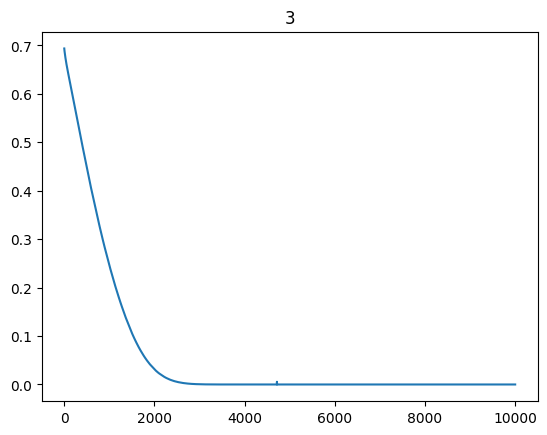

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.617760005388774
200 0.5421245533461666
300 0.4697881958940452
400 0.4031771003615623
500 0.340782227104201
600 0.2822830207353712
700 0.2281107026353185
800 0.17789552364425332
900 0.13330925765502108
1000 0.09513361461679729
1100 0.06394297296327411
1200 0.040383596685441135
1300 0.02367679807859674
1400 0.012832116948522848
1500 0.006376814014990542
1600 0.0028913418343518957
1700 0.0011801238011399863
1800 0.000434987739686667
1900 0.00014432196771582218
2000 4.271368320409167e-05
2100 1.1266539516719942e-05
2200 2.6341081837922596e-06
2300 5.515720591027538e-07
2400 1.0798287529504876e-07
2500 2.4850862261251518e-08
2600 1.0934813337211881e-08
2700 8.539158312127514e-09
2800 5.430500913307182e-09
2900 1.4717694536128195e-09
3000 1.1611004044776258e-09
3100 7.367685266975593e-10
3200 8.621543040109543e-10


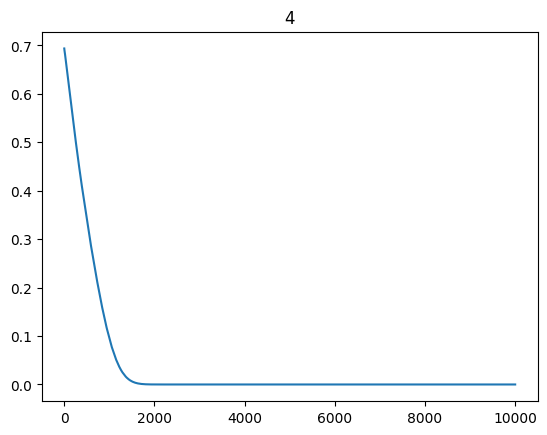

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6009642813427775
200 0.4998053984314791
300 0.40682135551583537
400 0.3188514178436177
500 0.2383078463083388
600 0.16769322252594968
700 0.10870760611678448
800 0.06411051480830009
900 0.03360276464281567
1000 0.015488527413895897
1100 0.006145571296870271
1200 0.0020734694236821003
1300 0.0005889808389303442
1400 0.00013937956352011127
1500 2.7327093328173807e-05
1600 4.377982530540442e-06
1700 6.487510014338507e-07
1800 1.1729154045051846e-06


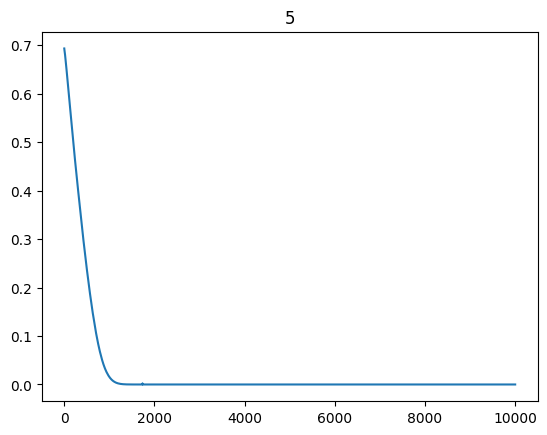

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.5944979563355448
200 0.49066124199067873
300 0.3886241053103229
400 0.2954273108465997
500 0.2118329096804647
600 0.14078691116004602
700 0.08484522319015338
800 0.045148316213824584
900 0.020739552455351633
1000 0.007995213129712887
1100 0.002562662370003048
1200 0.0006763514431761854
1300 0.00014544750951352072
1400 2.6436910725440634e-05
1500 5.176509886291121e-06
1600 2.8848919812506823e-05


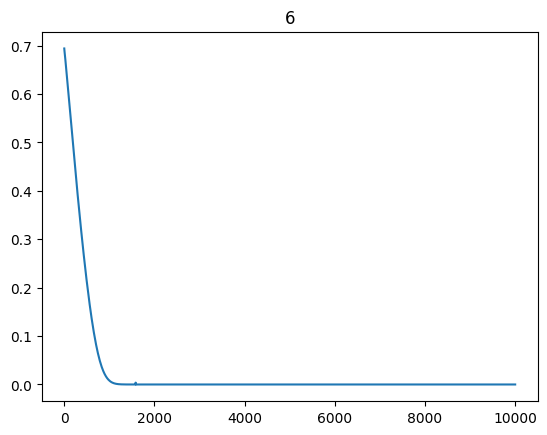

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.5939496551074233
200 0.4850584763814419
300 0.376644895576379
400 0.277820709691036
500 0.19210019357064193
600 0.12073169533601585
700 0.06655228039359345
800 0.03114581108093264
900 0.012069446461585663
1000 0.003757621225553985
1100 0.0009272865184660384
1200 0.00017950014877415546
1300 2.7867208843292922e-05
1400 7.835035695930572e-06
1500 2.9616638225966905e-06
1600 2.668584655561224e-07
1700 3.3078242655504725e-06


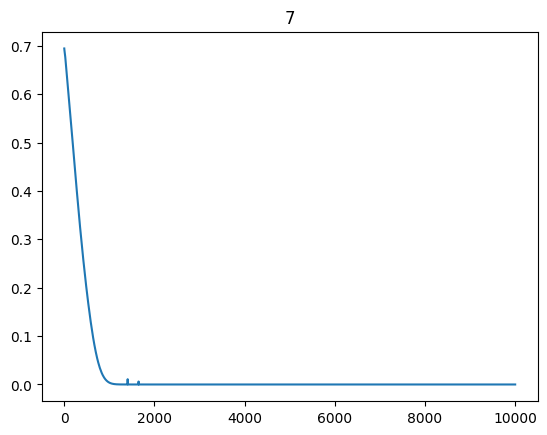

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.5693793295353063
200 0.4458740233790643
300 0.3306582664303917
400 0.22562273193662075
500 0.1367190269680292
600 0.07124299923067583
700 0.030481436976925562
800 0.01027220047499035
900 0.0026572209576888953
1000 0.0005189163505693774
1100 7.587769722454587e-05
1200 8.2597429361479e-06
1300 1.1753083367331526e-05


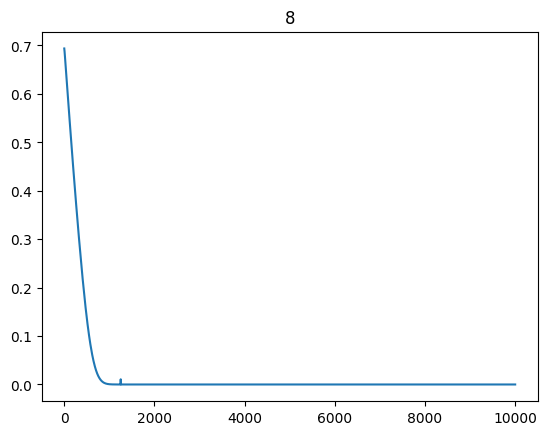

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.5493995417274682
200 0.40861982939874436
300 0.28105436762173996
400 0.17564824957619696
500 0.09436838238445279
600 0.04080850427842461
700 0.013447857930954994
800 0.0032414296140047443
900 0.000554802860421535
1000 6.594078581433589e-05
1100 8.175562903025094e-06
1200 1.0817372805400494e-05


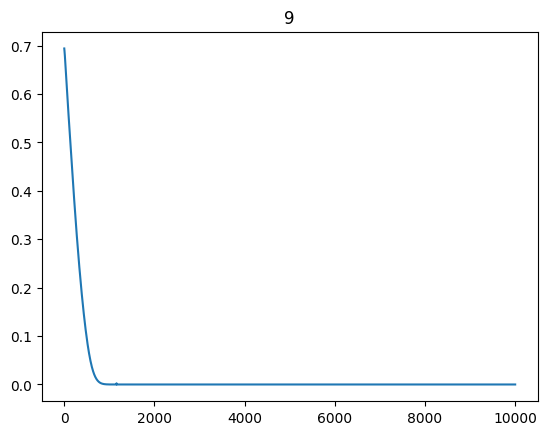

In [46]:

seq_list      = np.arange(3,10)
accuracy_list = []
pred_dic      = {}

for i in seq_list:
    
    seq_len = i
    
    model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()
    x_size = model(test_x)
    
    model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))
    
    
    train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
    loss       = train_tool.Training()
    plt.plot(loss)
    plt.title(f'{i}')
    plt.show()
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    accuracy,pred_numpy = test_tool.predict()

    pred_dic[i] = pred_numpy
    accuracy_list.append(accuracy)


In [47]:
# torch.save(pred_dic,f'./pred_samsung_CNN,kospi_multi')

In [ ]:
for x,y in Train_Data_Loader:
    break
print(x.size())

In [ ]:
seq_len=np.arange(3,10)

In [ ]:
accuracy_list

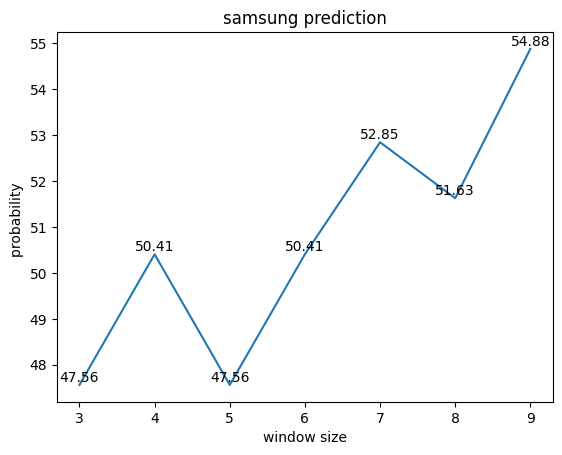

In [48]:
plt.plot(seq_list,accuracy_list)
for i in range(len(accuracy_list)):
    height = round(accuracy_list[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [ ]:
# torch.save(accuracy_list,'./pred_samsung_add_cnn,kospi')

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.5073281063460835
200 0.3223494875664805
300 0.17118152659203764
400 0.06684121183535158
500 0.016665232989408637
600 0.002460970155612707
700 0.00020718050115299457
800 0.0026528888006780832


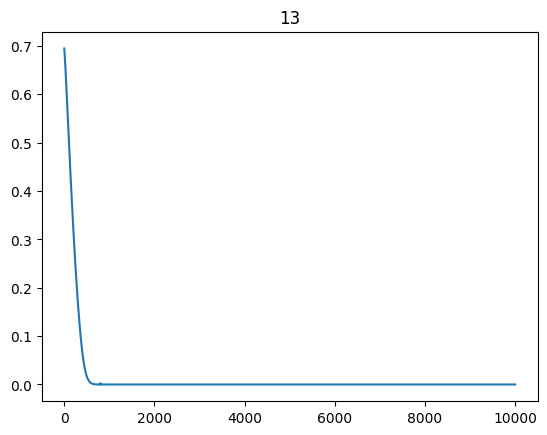

In [28]:
seq_list      = np.arange(13,14)
accuracy_list = []
pred_dic      = {}

for i in seq_list:
    
    seq_len = i
    
    model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()
    x_size = model(test_x)
    
    model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))
    
    
    train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
    loss       = train_tool.Training()
    plt.plot(loss)
    plt.title(f'{i}')
    plt.show()
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    accuracy,pred_numpy = test_tool.predict()

    pred_dic[i] = pred_numpy
    accuracy_list.append(accuracy)

In [29]:
seq_list     = np.arange(3,14)
accuracy_lst = []

for i in seq_list:
    seq_len = i 
    
    model   = NN_and_data(i,batch_size,lr,epochs,data_file
                 ,each_epoch)


    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

    x_size = model(test_x)

    model   = NN_and_data_(i,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))

    save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_CNN_kospi_multi.pt')

    model.load_state_dict(save_file['model_state_dict'])

    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)

    accuracy,pred_numpy = test_tool.predict()

    accuracy_lst.append(accuracy)

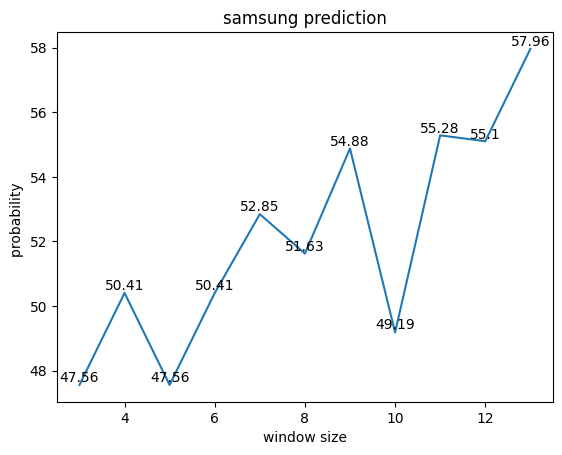

In [30]:
plt.plot(seq_list,accuracy_lst)
for i in range(len(accuracy_lst)):
    height = round(accuracy_lst[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [32]:
# torch.save(accuracy_lst,'./samsung_add_cnn,kospi')